# Préparation des données

## Import et data augmentations

In [1]:
from  src.dataloader import *
from src.metrics import *
from src.resnet18 import *
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.nn as nn
import tensorflow as tf
import keras
import keras.layers as layers
from keras.losses import BinaryCrossentropy
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer, f1_score, accuracy_score, recall_score, fbeta_score, precision_recall_curve, auc, roc_curve
import torchvision.models as models

c:\Users\yanis\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] La procédure spécifiée est introuvable
  warn(f"Failed to load image Python extension: {e}")


721


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])
tensor(0)


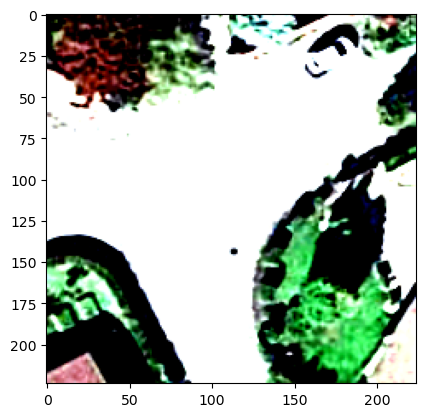

In [2]:
np.random.seed(123)
path_train="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/train_data.csv"
path_test="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/test_data.csv"

transformed_train_dataset  = CustomImageDataset(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(224),
                                               transforms.RandomCrop(190), #On garde environ 75% de l'image
                                               transforms.ColorJitter(brightness=(0.5,1.5),contrast=0,saturation=0,hue=0),                                               transforms.RandomCrop(160),
                                               transforms.Resize(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = [0.3492203652858734, 0.3565990626811981, 0.3071053624153137],
                                                                    std= [0.2003859430551529, 0.18338431417942047, 0.17826561629772186]),

                                           ]))

transformed_test_dataset = CustomImageDataset(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                            transform=transforms.Compose([
                                               transforms.Resize(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = [0.3498302698135376, 0.3575190603733063, 0.30798372626304626],
                                                                    std= [0.20142625272274017, 0.1843339055776596, 0.17957480251789093]),
                                           ]))

train_dataloader_augmente = DataLoader(transformed_train_dataset, batch_size=32, shuffle=True)
test_dataloader_augmente = DataLoader(transformed_test_dataset, batch_size=32, shuffle=True)

print(len(train_dataloader_augmente))
batch = next(iter(train_dataloader_augmente))
print(batch[0].shape)
plt.imshow(batch[0][0].permute(1, 2, 0))
print(batch[1][0])

In [71]:
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [78]:
resnet18 = models.resnet18(pretrained=True)

#Furthermore, in feature extracting, we don't need to calculate gradient for any layers except 
# the last layer that we initialize. For this we need to set .requires_grad to False
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(resnet18)
resnet18.fc = nn.Sequential(nn.Flatten(), #On change les couches finales pour adapter le réseau au contexte de classification binaire
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Dropout(0.2),
    nn.Linear(128, 2),
    nn.Sigmoid())

resnet18.layer1.append(nn.Dropout(0.1))
resnet18.layer2.append(nn.Dropout(0.6))
resnet18.layer3.append(nn.Dropout(0.3))
resnet18.layer4.append(nn.Dropout(0.8))


Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [73]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [87]:
def train_model(model, train_loader, criterion, n_epochs, device=None):
    # number of epochs to train the model

    # lists to be plotted at the end of the training

    train_losses= []
    train_f1s=[]
    train_accuracys=[]
    train_recalls=[]
    train_f2s=[]

    # Here we only want to update the gradient for the classifier layer that we initialized.
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

    optimizer=torch.optim.SGD(params_to_update, lr = 0.01, momentum=0.9, weight_decay=1e-4)
    
    for epoch in range(n_epochs):

        # monitor losses
        train_loss = 0

        train_f1=0

        train_accuracy=0

        train_recall=0

        train_f2=0

        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        for data,label in train_loader:
            
            # Pour utiliser GPU

            # inputs = inputs.to(device)
            # labels = labels.to(device)
            # model.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss

            _, preds = torch.max(output, 1)
  *
            # output=output.reshape(output.shape[0])
            loss = criterion(output.reshape(-1,1),label.reshape(-1,1))
            f1 = f1_score(label, preds)
            accuracy= accuracy_score(label, preds)
            recall= recall_score(label, preds)
            f2=fbeta_score(label, preds, beta=2)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item() * data.size(0)
            train_f1+=f1
            train_accuracy+=accuracy
            train_recall+=recall
            train_f2+=f2    

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = train_loss / len(train_loader.sampler) 
        valid_loss = valid_loss / len(valid_loader.sampler)

        train_f1=train_f1/len(train_loader.sampler)
        val_f1=val_f1/len(valid_loader.sampler)

        train_accuracy=train_accuracy/len(train_loader.sampler)
        val_accuracy=val_accuracy/len(valid_loader.sampler)

        train_recall=train_recall/len(train_loader.sampler)
        val_recall=val_recall/len(valid_loader.sampler)

        train_f2=train_f2/len(train_loader.sampler)
        val_f2=val_f2/len(valid_loader.sampler)

        train_losses.append(train_loss)
        val_losses.append(valid_loss)

        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        train_accuracys.append(train_accuracy)
        val_accuracys.append(val_accuracy)

        train_recalls.append(train_recall)
        val_recalls.append(val_recall)

        train_f2s.append(train_f2)
        val_f2s.append(val_f2)


        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch+1, 
            train_loss,
            train_f1,
            train_accuracy,
            train_recall,
            train_f2,
            ))

    # plot of the losses
    
    # fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # axs[0].plot([*range(len(train_losses))], train_losses / np.sum(train_losses), label = "Train loss")
    # axs[0].plot([*range(len(val_losses))], val_losses / np.sum(val_losses), label = "Val loss")
    # axs[0].legend()
    # plt.show()

    # axs[1].plot([*range(len(train_losses))], train_f1s / np.sum(train_f1s), label = "Train F1-score")
    # axs[1].plot([*range(len(val_losses))], val_f1s / np.sum(val_f1s), label = "Val F1-score")
    # axs[1].legend()
    # plt.show()
    torch.save(model.state_dict())
    
    return train_losses, train_f1s, train_accuracys, train_recalls, train_f2s    

In [88]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup the loss function
criterion = nn.BCELoss()

# Train model
train_losses, train_f1s, train_accuracys, train_recalls, train_f2s = train_model(model=resnet18, train_loader=train_dataloader_augmente, criterion=criterion,n_epochs=20)

	 fc.1.weight
	 fc.1.bias
	 fc.4.weight
	 fc.4.bias
tensor([[1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1]])
tensor([[0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0]])


RuntimeError: "binary_cross_entropy" not implemented for 'Long'

In [65]:
truc=torch.tensor([[0.5255],
        [0.5725],
        [0.5052],
        [0.4657],
        [0.6103],
        [0.5499],
        [0.6301],
        [0.6804],
        [0.5295],
        [0.5437],
        [0.4832],
        [0.5989],
        [0.4933],
        [0.5023],
        [0.5435],
        [0.5427],
        [0.4637],
        [0.5576],
        [0.5812],
        [0.5893],
        [0.6055]])
torch.max(torch.sigmoid(truc), 1)

torch.return_types.max(
values=tensor([0.6284, 0.6393, 0.6237, 0.6144, 0.6480, 0.6341, 0.6525, 0.6638, 0.6294,
        0.6327, 0.6185, 0.6454, 0.6209, 0.6230, 0.6326, 0.6324, 0.6139, 0.6359,
        0.6413, 0.6432, 0.6469]),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
        
def eval_model(model, valid_loader, criterion,n_epochs)
    ######################    
    # validate the model #
    ######################
    valid_loss_min = np.Inf  # set initial "min" to infinity
    val_losses= []
    val_f1s=[]
    val_accuracys=[]
    val_recalls=[]
    val_f2s=[]
    proba_predites=np.array([])

    # Here we only want to update the gradient for the classifier layer that we initialized.
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

    optimizer=torch.optim.SGD(params_to_update, lr = 0.01, momentum=0.9, weight_decay=1e-4)
    model.eval()  # prep model for evaluation

    for data,label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        print(output)
        proba_predites=np.append(proba_predites, output)
        # calculate the loss
        _, preds = torch.max(output, 1)

        loss = criterion(output,label)
        f1 = f1_score(label, preds)
        accuracy= accuracy_score(label, preds)
        recall= recall_score(label, preds)
        f2=fbeta_score(label, preds, beta=2)

        # update running validation loss 
        valid_loss = loss.item() * data.size(0)
        val_f1+=f1
        val_accuracy+=accuracy
        val_recall+=recall
        val_f2+=f2

In [73]:
train_losses, val_losses, train_f1s, val_f1s, train_accurys, val_accuracys, train_recalls, val_recalls, train_f2s, val_f2s, prob_predites=fit_pred_model(model=resnet18,
                                                                                                                                                            train_loader=train_dataloader_augmente,
                                                                                                                                                            valid_loader=test_dataloader_augmente, 
                                                                                                                                                            criterion=nn.CrossEntropyLoss(),
                                                                                                                                                            n_epochs=1)

tensor([[ 1.9015, -0.8246],
        [ 3.4191, -2.8841],
        [ 3.7242, -1.9565],
        [ 3.0872, -3.2137],
        [ 3.0584, -2.3900],
        [ 4.3919, -3.9154],
        [ 1.1743, -0.9834],
        [ 4.0051, -3.1400],
        [ 6.7472, -7.0053],
        [ 5.2803, -4.7876],
        [ 1.6158, -0.8351],
        [-0.2116,  1.0989],
        [ 4.0447, -3.7813],
        [-1.0347,  0.9659],
        [ 3.7864, -3.2063],
        [ 6.0066, -5.7489],
        [ 3.2419, -2.2165],
        [ 4.3830, -3.8713],
        [ 1.4630, -0.3545],
        [ 6.0886, -5.5487],
        [ 3.2361, -2.2346],
        [ 1.3945, -0.4536],
        [ 4.5474, -4.0224],
        [ 0.1727,  0.6851],
        [ 4.6652, -4.5531],
        [ 5.6585, -5.2497],
        [ 8.6428, -8.3792],
        [ 1.5043, -1.8450],
        [ 1.6157, -0.6312],
        [ 3.3115, -2.2703],
        [ 0.9883, -0.4016],
        [ 1.8868, -0.6781]], grad_fn=<AddmmBackward0>)


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

# Lancement du modèle

Les cinq premières métriques représentent les performances de notre algorithme sur l'échantillon d'entrainement, les cinq dernières valeurs (celles précédées du préfixe val_) sont elles calculées sur l'échantillon de test. 

In [ ]:
# model_init = buildModel()
# history=model_init.fit(x = X_train_permute.numpy(), y = Y_train.numpy(),
# 	validation_data=(X_test_permute.numpy(), Y_test.numpy()),
# 	batch_size=32,
# 	epochs=20)

In [ ]:
# recall = history.history['recall_m']
# val_recall = history.history['val_recall_m']

# accuracy = history.history['Accuracy']
# val_accuracy = history.history['val_Accuracy']

# precision = history.history['precision_m']
# val_precision = history.history['val_precision_m']

# f1 = history.history['f1_m']
# val_f1 = history.history['val_f1_m']

# f2 = history.history['f2_m']
# val_f2 = history.history['val_f2_m']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(1, len(recall) + 1)

# fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# axs[0, 0].plot(epochs, loss, 'b', label="Loss sur l'échantillon d'apprentissage")
# axs[0, 0].plot(epochs, val_loss, 'b', label="Loss sur l'échantillon test", color="red")
# axs[0, 0].set_title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
# axs[0, 0].legend()

# axs[0, 1].plot(epochs, accuracy, 'b', label="Accuracy sur l'échantillon d'apprentissage")
# axs[0, 1].plot(epochs, val_accuracy, 'b', label="Accuracy sur l'échantillon test", color="red")
# axs[0, 1].set_title("Accuracy sur l'échantillon d'apprentissage et l'échantillon test")
# axs[0, 1].legend()

# axs[1, 0].plot(epochs, precision, 'b', label="Precision sur l'échantillon d'apprentissage")
# axs[1, 0].plot(epochs, val_precision, 'b', label="Precision sur l'échantillon test", color="red")
# axs[1, 0].set_title("Precision sur l'échantillon d'apprentissage et l'échantillon test")
# axs[1, 0].legend()

# axs[1, 1].plot(epochs, recall, 'b', label="Recall sur l'échantillon d'apprentissage")
# axs[1, 1].plot(epochs, val_recall, 'b', label="Recall sur l'échantillon test", color="red")
# axs[1, 1].set_title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
# axs[1, 1].legend()

# axs[2, 0].plot(epochs, f1, 'b', label="F1-score sur l'échantillon d'apprentissage")
# axs[2, 0].plot(epochs, val_f1, 'b', label="F1-score sur l'échantillon test", color="red")
# axs[2, 0].set_title("F1-score sur l'échantillon d'apprentissage et l'échantillon test")
# axs[2, 0].legend()

# axs[2, 1].plot(epochs, f2, 'b', label="F2-score sur l'échantillon d'apprentissage")
# axs[2, 1].plot(epochs, val_f2, 'b', label="F2-score sur l'échantillon test", color="red")
# axs[2, 1].set_title("F2-score sur l'échantillon d'apprentissage et l'échantillon test")
# axs[2, 1].legend()

# plt.show()

In [ ]:
# train_loss, train_accuracy, train_recall, train_precision, train_f1score, train_f2score = model_init.evaluate(
#     X_train_permute.numpy(), Y_train.numpy(), verbose=0)
# print("Loss sur l'échantillon train: {}".format(round(train_loss, 3)))
# print("Accuracy sur l'échantillon train: {}".format(round(train_accuracy, 3)))
# print("Recall sur l'échantillon train: {}".format(round(train_recall, 3)))
# print("Precision sur l'échantillon train: {}".format(round(train_precision, 3)))
# print("F1-score sur l'échantillon train: {}".format(round(train_f1score, 3)))
# print("F2-score sur l'échantillon train: {}".format(round(train_f2score, 3)))

# loss, accuracy, recall, precision, f1score, f2score = model_init.evaluate(
#     X_test_permute.numpy(), Y_test.numpy(), verbose=0)
# print("Loss sur l'échantillon test: {}".format(round(loss, 3)))
# print("Accuracy sur l'échantillon test: {}".format(round(accuracy, 3)))
# print("Recall sur l'échantillon test: {}".format(round(recall, 3)))
# print("Precision sur l'échantillon test: {}".format(round(precision, 3)))
# print("F1-score sur l'échantillon test: {}".format(round(f1score, 3)))
# print("F2-score sur l'échantillon test: {}".format(round(f2score, 3)))

# prob_predict = model_init.predict(X_test_permute.numpy())
# y_pred = (np.squeeze(prob_predict) > 0.5).astype("int32")

# unique, counts = np.unique(y_pred, return_counts=True)
# res=dict(zip(unique, counts))
# print("Nombre d'images prédites avec panneaux: {}".format(res[1]))
# print("Nombre d'images prédites sans panneau: {}".format(res[0]))

Loss sur l'échantillon test: 1.064
Accuracy sur l'échantillon test: 0.438
Recall sur l'échantillon test: 0.706
Precision sur l'échantillon test: 0.48
F1-score sur l'échantillon test: 0.571


# Hyperparamétrisation du ResNet-18

In [ ]:
# learnRate = [1e-2, 1e-3, 1e-4]
# momentum = [0.9, 0.99]
# dropout1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout3 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout4 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout5 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# weight_decay=[1e-4, 1e-6]
# batchSize = [4, 8, 16, 32, 64, 128, 256]
# epochs = [10, 20, 30, 40, 50]

# grid = dict(
#     learnRate=learnRate,
#     momentum=momentum,
#     dropout1=dropout1,
#     dropout2=dropout2,
#     dropout3=dropout3,
#     dropout4=dropout4,
#     dropout5=dropout5,
#     weight_decay=weight_decay,
#     batch_size=batchSize,
#     epochs=epochs
# )

# model = KerasClassifier(build_fn=buildModel, verbose=1)
# ftwo_scorer = make_scorer(fbeta_score, beta=2)

# searcher = RandomizedSearchCV(
#     estimator=model, cv=5, n_iter=10, param_distributions=grid, scoring=ftwo_scorer)
# searchResults = searcher.fit(
#     X_train_augmente_permute.numpy(), Y_train_augmente.numpy())
